     n    m  ratio          solver  penetrance   avg_time  count
0   20   60   3.00          Beam-3         0.4   0.592172      5
1   20   60   3.00          Beam-4         0.0   1.431058      5
2   20   60   3.00      Hill-Climb         0.8   0.003956      5
3   20   60   3.00  Hill-Climb-Lit         0.0   0.017102      5
4   20   60   3.00             VND         0.8   0.010875      5
5   20   60   3.00         VND-Lit         0.0   0.033218      5
6   20   85   4.25          Beam-3         0.2   1.172257      5
7   20   85   4.25          Beam-4         0.6   0.717750      5
8   20   85   4.25      Hill-Climb         0.2   0.013904      5
9   20   85   4.25  Hill-Climb-Lit         0.0   0.033616      5
10  20   85   4.25             VND         0.6   0.017462      5
11  20   85   4.25         VND-Lit         0.0   0.042005      5
12  50  150   3.00          Beam-3         0.0   7.272433      5
13  50  150   3.00          Beam-4         0.6   3.396287      5
14  50  150   3.00      H

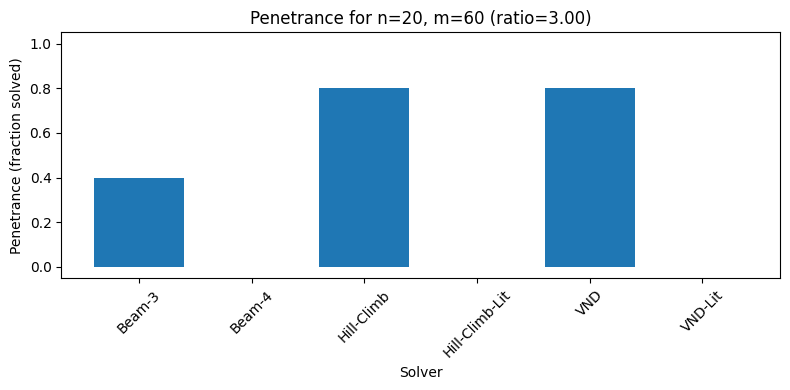

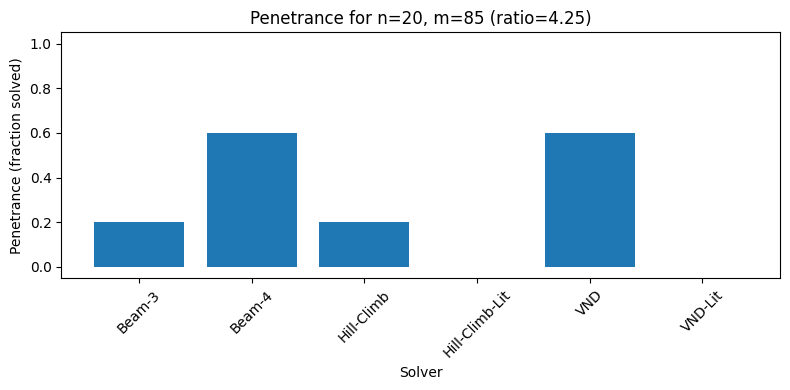

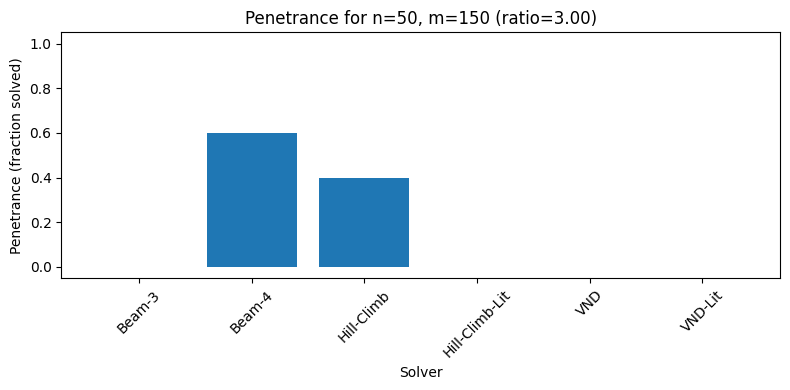

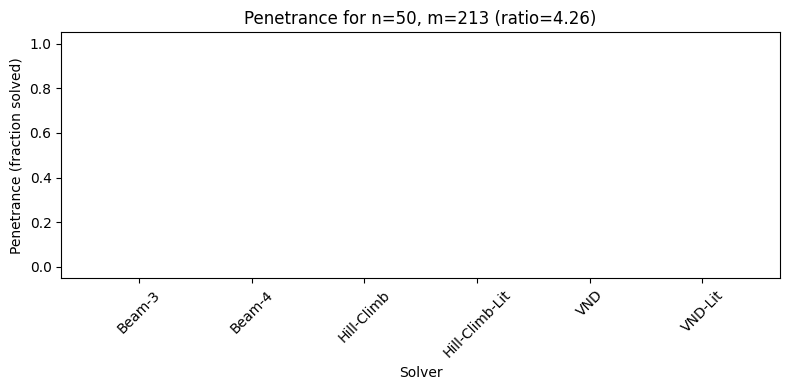

In [ ]:
import random
import time
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- SAT instance generator ----------
def generate_uniform_k_sat(k, m, n, seed=None):
    if seed is not None:
        random.seed(seed)
    clauses = set()
    attempts = 0
    while len(clauses) < m and attempts < m*50:
        vars_ = random.sample(range(1, n+1), k)
        lits = []
        for v in vars_:
            if random.random() < 0.5:
                lits.append(v)   # positive literal
            else:
                lits.append(-v)  # negative literal
        clause = tuple(sorted(lits, key=lambda x: (abs(x), x)))
        if len(set(map(abs, clause))) == k:
            clauses.add(clause)
        attempts += 1
    if len(clauses) < m:
        raise ValueError("Couldn't generate enough distinct clauses. Try different parameters.")
    return list(clauses)

# ---------- SAT evaluation helpers ----------
def eval_clause(clause, assignment):
    for lit in clause:
        var = abs(lit)
        val = assignment[var]
        if lit < 0:
            val = not val
        if val:
            return True
    return False

def satisfied_clauses_count(clauses, assignment):
    return sum(1 for c in clauses if eval_clause(c, assignment))

def satisfied_literals_count(clauses, assignment):
    cnt = 0
    for c in clauses:
        for lit in c:
            var = abs(lit)
            val = assignment[var]
            if lit < 0:
                val = not val
            if val:
                cnt += 1
    return cnt

# ---------- Random initial assignment ----------
def random_assignment(n):
    return {i: random.random() < 0.5 for i in range(1, n+1)}

# ---------- Neighbors generators ----------
def neighbors_flip_k(assignment, k):
    vars_list = list(assignment.keys())
    for combo in itertools.combinations(vars_list, k):
        new = assignment.copy()
        for v in combo:
            new[v] = not new[v]
        yield new

def neighbors_flip_1(assignment):
    yield from neighbors_flip_k(assignment, 1)

def neighbors_flip_2(assignment):
    yield from neighbors_flip_k(assignment, 2)

def neighbors_flip_3(assignment):
    yield from neighbors_flip_k(assignment, 3)

# ---------- Solvers ----------
def hill_climbing(clauses, n, heuristic='clauses', max_iters=5000, restarts=10):
    start_time = time.time()
    best_score = -1
    for r in range(restarts):
        assignment = random_assignment(n)
        current_score = satisfied_clauses_count(clauses, assignment) if heuristic=='clauses' else satisfied_literals_count(clauses, assignment)
        iters = 0
        while iters < max_iters:
            iters += 1
            neighbor_best = None
            neighbor_best_score = current_score
            for v in range(1, n+1):
                new = assignment.copy()
                new[v] = not new[v]
                score = satisfied_clauses_count(clauses, new) if heuristic=='clauses' else satisfied_literals_count(clauses, new)
                if score > neighbor_best_score:
                    neighbor_best_score = score
                    neighbor_best = new
            if neighbor_best is None:
                break
            assignment = neighbor_best
            current_score = neighbor_best_score
            if current_score == len(clauses):
                return True, time.time() - start_time
        if current_score > best_score:
            best_score = current_score
    return False, time.time() - start_time

def beam_search(clauses, n, beam_width=3, heuristic='clauses', max_iters=5000):
    start_time = time.time()
    beam = [random_assignment(n) for _ in range(beam_width)]
    iters = 0
    while iters < max_iters:
        iters += 1
        all_neighbors = []
        for a in beam:
            for v in range(1, n+1):
                new = a.copy()
                new[v] = not new[v]
                score = satisfied_clauses_count(clauses, new) if heuristic=='clauses' else satisfied_literals_count(clauses, new)
                all_neighbors.append((score, new))
                if score == len(clauses):
                    return True, time.time() - start_time
        all_neighbors.sort(key=lambda x: x[0], reverse=True)
        beam = [x[1] for x in all_neighbors[:beam_width]]
    return False, time.time() - start_time

def vnd(clauses, n, neighborhoods, heuristic='clauses', max_iters=5000, explore_limit_per_neighborhood=2000):
    start_time = time.time()
    assignment = random_assignment(n)
    current_score = satisfied_clauses_count(clauses, assignment) if heuristic=='clauses' else satisfied_literals_count(clauses, assignment)
    iters = 0
    while iters < max_iters:
        improved = False
        for neigh in neighborhoods:
            neighbor_best = None
            neighbor_best_score = current_score
            explored = 0
            for new in neigh(assignment):
                explored += 1
                if explored > explore_limit_per_neighborhood:
                    break
                score = satisfied_clauses_count(clauses, new) if heuristic=='clauses' else satisfied_literals_count(clauses, new)
                if score > neighbor_best_score:
                    neighbor_best_score = score
                    neighbor_best = new
                if score == len(clauses):
                    return True, time.time() - start_time
            if neighbor_best is not None:
                assignment = neighbor_best
                current_score = neighbor_best_score
                improved = True
                break
        if not improved:
            break
        iters += 1
    return current_score == len(clauses), time.time() - start_time

# ---------- Experiment runner ----------
def run_experiment(k, combos, instances_per_combo=20):
    random.seed(42)
    results = []
    for (n, m) in combos:
        for inst_idx in range(instances_per_combo):
            clauses = generate_uniform_k_sat(k, m, n)
            solvers = [
                ('Hill-Climb', lambda: hill_climbing(clauses, n, heuristic='clauses', max_iters=2000, restarts=5)),
                ('Hill-Climb-Lit', lambda: hill_climbing(clauses, n, heuristic='literals', max_iters=2000, restarts=5)),
                ('Beam-3', lambda: beam_search(clauses, n, beam_width=3, heuristic='clauses', max_iters=1000)),
                ('Beam-4', lambda: beam_search(clauses, n, beam_width=4, heuristic='clauses', max_iters=1000)),
                ('VND', lambda: vnd(clauses, n, neighborhoods=[neighbors_flip_1, neighbors_flip_2, neighbors_flip_3], heuristic='clauses', max_iters=1000)),
                ('VND-Lit', lambda: vnd(clauses, n, neighborhoods=[neighbors_flip_1, neighbors_flip_2, neighbors_flip_3], heuristic='literals', max_iters=1000))
            ]
            for name, func in solvers:
                start = time.time()
                solved, t = func()
                elapsed = time.time() - start
                results.append({
                    'n': n, 'm': m, 'ratio': round(m/n, 3), 'instance': inst_idx,
                    'solver': name, 'solved': int(solved), 'time': elapsed
                })
    df = pd.DataFrame(results)
    return df

# ---------- Example usage ----------
if __name__ == "__main__":

    combos = [
        (20, 60),   # ratio 3.0
        (20, 85),   # ratio 4.25
        (50, 150),  # ratio 3.0
        (50, 213)   # ratio ~4.26
    ]
    # For a quick local test set instances_per_combo small (e.g., 5)
    df = run_experiment(3, combos, instances_per_combo=5)
    summary = df.groupby(['n','m','ratio','solver']).agg(
        penetrance=('solved','mean'),
        avg_time=('time','mean'),
        count=('solved','size')
    ).reset_index()
    print(summary)
    summary.to_csv('sat_experiment_summary.csv', index=False)
    # Plot example: one plot per combo
    for (n,m,ratio), group in summary.groupby(['n','m','ratio']):
        plt.figure(figsize=(8,4))
        x = group['solver']
        y = group['penetrance']
        plt.title(f'Penetrance for n={n}, m={m} (ratio={ratio:.2f})')
        plt.xlabel('Solver')
        plt.ylabel('Penetrance (fraction solved)')
        plt.ylim(-0.05,1.05)
        plt.bar(x, y)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()